In [1]:
import itertools
import random

import torch
from torch.nn import Linear
from torch.nn import functional as F
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, MessagePassing, TopKPooling
from torch_geometric.transforms import NormalizeFeatures
from torch_scatter import scatter_mean

from custom.args import grey, purple
from custom.dataset import GraphDataset, create_dataset
from custom.utils import *

In [2]:
class GraphMatchingConvolution(MessagePassing):
    def __init__(self, in_channels, out_channels, args, aggr="add"):
        super(GraphMatchingConvolution, self).__init__(aggr=aggr)
        self.args = args
        self.lin_node = torch.nn.Linear(in_channels, out_channels)
        self.lin_message = torch.nn.Linear(out_channels * 2, out_channels)
        self.lin_passing = torch.nn.Linear(out_channels + in_channels, out_channels)
        self.batch_norm = BatchNorm(out_channels)

    def forward(self, x, edge_index, batch):
        x_transformed = self.lin_node(x)
        return self.propagate(edge_index, x=x_transformed, original_x=x, batch=batch)

    def message(self, edge_index_i, x_i, x_j):
        x = torch.cat([x_i, x_j], dim=1)
        m = self.lin_message(x)
        return m

    def update(self, aggr_out, edge_index, x, original_x, batch):
        n_graphs = torch.unique(batch).shape[0]
        cross_graph_attention, a_x, a_y = batch_block_pair_attention(
            original_x, batch, n_graphs
        )
        attention_input = original_x - cross_graph_attention
        aggr_out = self.lin_passing(torch.cat([aggr_out, attention_input], dim=1))
        aggr_out = self.batch_norm(aggr_out)
        return (
            aggr_out,
            edge_index,
            batch,
            (attention_input, cross_graph_attention, a_x, a_y),
        )


class GraphAggregator(torch.nn.Module):
    def __init__(self, in_channels, out_channels, args):
        super(GraphAggregator, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.lin_gate = torch.nn.Linear(in_channels, out_channels)
        self.lin_final = torch.nn.Linear(out_channels, out_channels)
        self.args = args

    def forward(self, x, edge_index, batch):
        x_states = self.lin(x)
        x_gates = torch.nn.functional.softmax(self.lin_gate(x), dim=1)
        x_states = x_states * x_gates
        x_states = scatter_mean(x_states, batch, dim=0)
        x_states = self.lin_final(x_states)
        return x_states

In [15]:
class GraphMatchingNetwork(torch.nn.Module):
    def __init__(self, args):
        super(GraphMatchingNetwork, self).__init__()
        self.args = args
        self.margin = self.args.margin
        if args.n_classes > 2:
            self.f1_average = "micro"
        else:
            self.f1_average = "binary"
        self.layers = torch.nn.ModuleList()
        self.layers.append(
            GraphMatchingConvolution(self.args.feat_dim, self.args.dim, args)
        )
        for _ in range(self.args.num_layers - 1):
            self.layers.append(
                GraphMatchingConvolution(self.args.dim, self.args.dim, args)
            )
        self.aggregator = GraphAggregator(self.args.dim, self.args.dim, self.args)
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.mincut = []
        self.mlp = torch.nn.Sequential()
        self.args.n_clusters = args.n_clusters
        self.mlp.append(Linear(self.args.dim, self.args.n_clusters))
        self.topk_pooling = TopKPooling(self.args.dim, ratio=8)
        self.topk_outputs = []

    def compute_emb(
        self, feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
    ):
        for i in range(self.args.num_layers):
            (
                feats,
                edge_index,
                batch,
                (attention_input, cross_graph_attention, a_x, a_y),
            ) = self.layers[i](feats, edge_index, batch)
            x_1 = feats[: sizes_1.item(), :]
            x_2 = feats[sizes_1.item() : sizes_1.item() + sizes_2.item(), :]
            x_pooled_1, edge_index_pooled_1, _, _, perm1, _ = self.topk_pooling(
                x_1,
                edge_index_1,
            )
            x_pooled_2, edge_index_pooled_2, _, _, perm2, _ = self.topk_pooling(
                x_2,
                edge_index_2,
            )
            self.topk_outputs.append(
                (
                    (x_pooled_1, edge_index_pooled_1, perm1),
                    (x_pooled_2, edge_index_pooled_2, perm2),
                )
            )
            self.layer_cross_attentions.append((cross_graph_attention, a_x, a_y))
            self.layer_outputs.append((x_1, x_2))

        feats = self.aggregator(feats, edge_index, batch)
        return feats, edge_index, batch

    def combine_pair_embedding(
        self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
    ):
        feats = torch.cat([feats_1, feats_2], dim=0)
        max_node_idx_1 = sizes_1.sum()
        edge_index_2_offset = edge_index_2 + max_node_idx_1
        edge_index = torch.cat([edge_index_1, edge_index_2_offset], dim=1)
        batch = create_batch(torch.cat([sizes_1, sizes_2], dim=0))
        feats, edge_index, batch = (
            feats.to(self.args.device),
            edge_index.to(self.args.device),
            batch.to(self.args.device),
        )
        return feats, edge_index, batch

    def forward(self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2):
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.topk_outputs = []
        self.mincut = []
        feats, edge_index, batch = self.combine_pair_embedding(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )
        emb, _, _ = self.compute_emb(
            feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
        )
        emb_1 = emb[: emb.shape[0] // 2, :]
        emb_2 = emb[emb.shape[0] // 2 :, :]

        best_acc1, best_acc2 = 0.0, 0.0
        cluster1, cluster2 = None, None
        layer1, layer2 = None, None
        for i in range(len(self.topk_outputs)):
            (
                (x_pooled_1, edge_index_pooled_1, perm1),
                (x_pooled_2, edge_index_pooled_2, perm2),
            ) = self.topk_outputs[i]
            acc1 = len(set(range(8)) & set(perm1.tolist()))
            acc2 = len(set(range(8)) & set(perm2.tolist()))
            if acc1 > best_acc1:
                cluster1 = Data(x=x_pooled_1, edge_index=edge_index_pooled_1)
                best_acc1 = acc1
                layer1 = i + 1
            if acc2 > best_acc2:
                cluster2 = Data(x=x_pooled_2, edge_index=edge_index_pooled_2)
                best_acc2 = acc2
                layer2 = i + 1

        return emb_1, emb_2, cluster1, cluster2, layer1, layer2

    def compute_metrics(self, emb_1, emb_2, labels):
        distances = torch.norm(emb_1 - emb_2, p=2, dim=1)
        loss = F.relu(self.margin - labels * (1 - distances)).mean()
        predicted_similar = torch.where(
            distances < self.args.margin,
            torch.ones_like(labels),
            -torch.ones_like(labels),
        )
        acc = (predicted_similar == labels).float().mean()
        metrics = {"loss": loss, "acc": acc}
        return metrics

    def init_metric_dict(self):
        return {"acc": -1, "f1": -1}

    def has_improved(self, m1, m2):
        return m1["acc"] < m2["acc"]

Total number of graphs: 360
Number of classes: 4
Number of node features: 4
Average number of nodes per graph: 10
Max number of nodes in a graph: 11
Min number of nodes in a graph: 9
Class distribution:
 - Class 1: 90 graphs (25.00%)
 - Class 0: 90 graphs (25.00%)
 - Class 2: 90 graphs (25.00%)
 - Class 3: 90 graphs (25.00%)


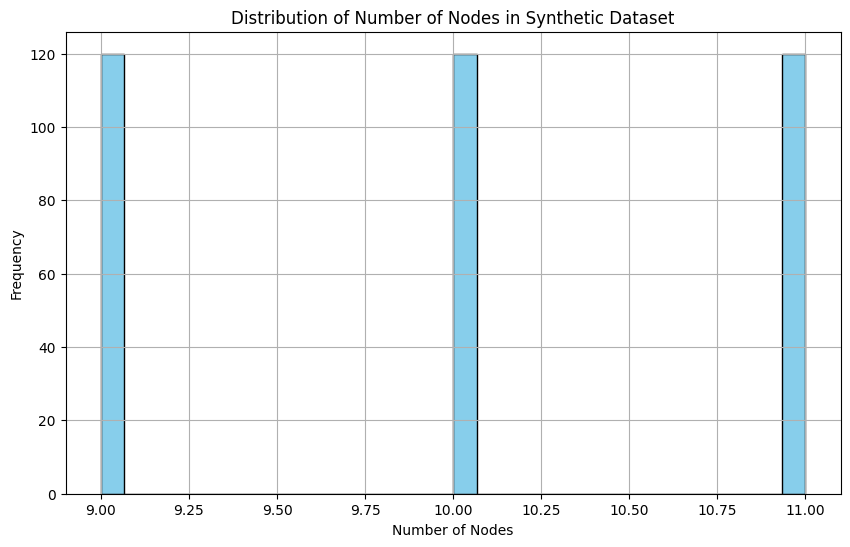

Small graphs: 360
Medium graphs: 0
Large graphs: 0


In [4]:
# dataset = TUDataset(
#     root="data", name="MUTAG", use_node_attr=True, transform=NormalizeFeatures()
# )

dataset = GraphDataset(torch.load("data/cycle_line_star_complete_1.pt"))

small_graphs, medium_graphs, large_graphs, classes = analyze_dataset(dataset)

In [ ]:
# class Args:
#     def __init__(self):
#         self.dim = 16
#         self.feat_dim = dataset.num_features
#         self.num_layers = 7
#         self.margin = 0.4
#         self.lr = 0.001
#         self.n_classes = dataset.num_classes
#         self.batch_size = 128
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.n_clusters = 8
#         self.num_pairs = 3000


# args = Args()

# pairs, labels = create_graph_pairs(dataset, args.num_pairs)
# # pair_dataset = [(pair, label) for pair, label in zip(pairs, labels)]
# # train_loader = DataLoader(
# #     pair_dataset,
# #     batch_size=args.batch_size,
# #     shuffle=True,
# #     collate_fn=collate_graph_pairs,
# # )

In [5]:
def train(model, optimizer, pairs, labels, batch_size):
    model.train()
    train_losses = []
    train_accuracies = []
    losses = []
    accs = []

    def get_params(model):
        return {name: param.clone() for name, param in model.named_parameters()}

    initial_params = get_params(model)

    for i in range(len(pairs)):
        optimizer.zero_grad()

        graph1, graph2 = pairs[i]
        label = labels[i]

        feats_1, edge_index_1 = graph1.x, graph1.edge_index
        feats_2, edge_index_2 = graph2.x, graph2.edge_index
        sizes_1 = torch.tensor([graph1.num_nodes])
        sizes_2 = torch.tensor([graph2.num_nodes])

        emb_1, emb_2, _, _, _, _ = model(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )

        metrics = model.compute_metrics(emb_1, emb_2, torch.tensor([label]))
        loss = metrics["loss"]
        acc = metrics["acc"]

        losses.append(loss)
        accs.append(acc)

        if i % batch_size == 0 and i > 0:
            batch_loss = torch.mean(torch.stack(losses))
            batch_acc = torch.mean(torch.stack(accs))
            losses = []
            accs = []
            train_losses.append(batch_loss.detach().numpy())
            train_accuracies.append(batch_acc.detach().numpy())
            batch_loss.backward()
            optimizer.step()
            # if i % 100 * batch_size == 0:
            #     print(
            #         f"Epoch: {i} - Loss: {batch_loss.item():.4f}, Acc: {batch_acc:.4f}"
            #     )

    trained_params = get_params(model)

    # for name in initial_params:
    #     initial_param = initial_params[name]
    #     trained_param = trained_params[name]
    #     if not torch.equal(initial_param, trained_param):
    #         print(f"Parameter {name} has changed.")
    #     else:
    #         print(f"Parameter {name} has NOT changed.")

    # plt.figure(figsize=(12, 5))

    # plt.subplot(1, 2, 1)
    # plt.plot(train_losses, label="Training Loss")
    # plt.title("Loss over Epochs")
    # plt.xlabel("Epochs")
    # plt.ylabel("Loss")
    # plt.legend()

    # plt.subplot(1, 2, 2)
    # plt.plot(train_accuracies, label="Training Accuracy")
    # plt.title("Accuracy over Epochs")
    # plt.xlabel("Epochs")
    # plt.ylabel("Accuracy")
    # plt.legend()

    # plt.show()

In [6]:
# model = GraphMatchingNetwork(args).to(args.device)
# optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)

# filename = f"checkpoints/checkpoint_{dataset.name.lower()}_{args.dim}_{args.num_layers}_{args.margin}_{args.lr}_{args.batch_size}.pth"

# if path.exists(filename):
#     checkpoint = torch.load(filename)
#     model.load_state_dict(checkpoint["model_state_dict"])
#     optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
#     for state in optimizer.state.values():
#         for k, v in state.items():
#             if isinstance(v, torch.Tensor):
#                 state[k] = v.to(args.device)
#     model.to(args.device)
# else:
#     train(model, optimizer, pairs, labels, args.batch_size)
#     # torch.save(
#     #     {
#     #         "model_state_dict": model.state_dict(),
#     #         "optimizer_state_dict": optimizer.state_dict(),
#     #     },
#     #     filename,
#     # )

In [7]:
def test(model, title="", layers=3):
    class_clusters = []
    class_accs = []
    for i in range(4):
        c = f"class_{str(i)}"
        idx1 = random.sample(range(len(classes[c])), 1)[0]
        idx2 = random.sample(range(len(classes[c])), 1)[0]
        graph1, graph2 = classes[c][idx1], classes[c][idx2]

        model.eval()

        feats_1, edge_index_1 = graph1.x, graph1.edge_index
        feats_2, edge_index_2 = graph2.x, graph2.edge_index
        sizes_1 = torch.tensor([len(graph1.x)])
        sizes_2 = torch.tensor([len(graph2.x)])
        _, _, cluster1, cluster2 = model(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )

        clusters = []
        accs = []

        for i in range(len(model.topk_outputs)):
            (
                (x_pooled_1, edge_index_pooled_1, perm1),
                (x_pooled_2, edge_index_pooled_2, perm2),
            ) = model.topk_outputs[i]
            clusters.append(
                (
                    Data(x=x_pooled_1, edge_index=edge_index_pooled_1),
                    Data(x=x_pooled_2, edge_index=edge_index_pooled_2),
                )
            )
            accs.append(
                (
                    len(set(range(8)) & set(perm1.tolist())),
                    len(set(range(8)) & set(perm2.tolist())),
                )
            )

        # if c == "class_0":
        #     print(is_cycle(cluster1), is_cycle(cluster2))
        # elif c == "class_1":
        #     print(is_complete(cluster1), is_complete(cluster2))
        # elif c == "class_2":
        #     print(is_line(cluster1), is_line(cluster2))
        # elif c == "class_3":
        #     print(is_star(cluster1), is_star(cluster2))

        acc = list(itertools.chain.from_iterable(zip(*accs)))
        class_accs.extend(acc)

        cs = list(itertools.chain.from_iterable(zip(*clusters)))
        class_clusters.extend(cs)
        # plot_graph_pair(cluster1, cluster2)

    plot_all_classes(class_clusters, class_accs, title, layers)

In [8]:
def plot_layer_barplot(class0, class1, class2, class3, n):
    counts0 = [class0.count(i) for i in range(1, n + 1)]
    counts1 = [class1.count(i) for i in range(1, n + 1)]
    counts2 = [class2.count(i) for i in range(1, n + 1)]
    counts3 = [class3.count(i) for i in range(1, n + 1)]

    fig, ax = plt.subplots(figsize=(15, 8))

    bar_width = 0.15

    indices = np.arange(1, n + 1)

    bars0 = ax.bar(indices - 1.5 * bar_width, counts0, width=bar_width, label="Class 0")
    bars1 = ax.bar(indices - 0.5 * bar_width, counts1, width=bar_width, label="Class 1")
    bars2 = ax.bar(indices + 0.5 * bar_width, counts2, width=bar_width, label="Class 2")
    bars3 = ax.bar(indices + 1.5 * bar_width, counts3, width=bar_width, label="Class 3")

    ax.set_xlabel("Number", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_title("Frequency of Numbers by Class", fontsize=16)

    ax.set_xticks(indices)
    ax.set_xticklabels([str(i) for i in indices])

    ax.legend()

    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f"{height}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    add_value_labels(bars0)
    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)

    plt.tight_layout()
    plt.show()

In [10]:
def acc_test(model, num_layers, print_results=True):
    correct_class0 = 0
    correct_class1 = 0
    correct_class2 = 0
    correct_class3 = 0
    best_class0 = 0
    best_class1 = 0
    best_class2 = 0
    best_class3 = 0
    layers_class0 = []
    layers_class1 = []
    layers_class2 = []
    layers_class3 = []
    sims = []
    for _ in range(500):
        for i in range(4):
            c = f"class_{str(i)}"
            idx1 = random.sample(range(len(classes[c])), 1)[0]
            idx2 = random.sample(range(len(classes[c])), 1)[0]
            graph1, graph2 = classes[c][idx1], classes[c][idx2]

            model.eval()

            feats_1, edge_index_1 = graph1.x, graph1.edge_index
            feats_2, edge_index_2 = graph2.x, graph2.edge_index
            sizes_1 = torch.tensor([len(graph1.x)])
            sizes_2 = torch.tensor([len(graph2.x)])
            emb1, emb2, cluster1, cluster2, layer1, layer2 = model(
                feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
            )

            sim = pairwise_cosine_similarity(emb1, emb2)

            if c == "class_0":
                layers_class0.append(layer1)
                layers_class0.append(layer2)
                # if not is_cycle(cluster1):
                #     plot_graph_pair(graph1, cluster1, c)
                # if not is_cycle(cluster2):
                #     plot_graph_pair(graph2, cluster2, c)
                correct_class0 += is_cycle(cluster1) + is_cycle(cluster2)
                best_class0 += any([is_cycle(cluster1), is_cycle(cluster2)])
                if not any([is_cycle(cluster1), is_cycle(cluster2)]):
                    sims.append(sim)
            elif c == "class_1":
                layers_class1.append(layer1)
                layers_class1.append(layer2)
                # if not is_complete(cluster1):
                #     plot_graph_pair(graph1, cluster1, c)
                # if not is_complete(cluster2):
                #     plot_graph_pair(graph2, cluster2, c)
                correct_class1 += is_complete(cluster1) + is_complete(cluster2)
                best_class1 += any([is_complete(cluster1), is_complete(cluster2)])
                if not any([is_complete(cluster1), is_complete(cluster2)]):
                    sims.append(sim)
            elif c == "class_2":
                layers_class2.append(layer1)
                layers_class2.append(layer2)
                # if not is_line(cluster1):
                #     plot_graph_pair(graph1, cluster1, c)
                # if not is_line(cluster2):
                #     plot_graph_pair(graph2, cluster2, c)
                correct_class2 += is_line(cluster1) + is_line(cluster2)
                best_class2 += any([is_line(cluster1), is_line(cluster2)])
                if not any([is_line(cluster1), is_line(cluster2)]):
                    sims.append(sim)
            elif c == "class_3":
                layers_class3.append(layer1)
                layers_class3.append(layer2)
                # if not is_star(cluster1):
                #     plot_graph_pair(graph1, cluster1, c)
                # if not is_star(cluster2):
                #     plot_graph_pair(graph2, cluster2, c)
                correct_class3 += is_star(cluster1) + is_star(cluster2)
                best_class3 += any([is_star(cluster1), is_star(cluster2)])
                if not any([is_star(cluster1), is_star(cluster2)]):
                    sims.append(sim)

    class0_acc = correct_class0 / 10
    class1_acc = correct_class1 / 10
    class2_acc = correct_class2 / 10
    class3_acc = correct_class3 / 10
    overall_acc = (class0_acc + class1_acc + class2_acc + class3_acc) / 4
    best_class0_acc = best_class0 / 5
    best_class1_acc = best_class1 / 5
    best_class2_acc = best_class2 / 5
    best_class3_acc = best_class3 / 5
    best_overall_acc = (
        best_class0_acc + best_class1_acc + best_class2_acc + best_class3_acc
    ) / 4
    # plot_layer_barplot(
    #     layers_class0, layers_class1, layers_class2, layers_class3, num_layers
    # )
    if print_results:
        print(f"Correct cycle predictions: {class0_acc:.1f}%")
        print(f"Correct complete predictions: {class1_acc:.1f}%")
        print(f"Correct line predictions: {class2_acc:.1f}%")
        print(f"Correct star predictions: {class3_acc:.1f}%")
        print(f"Overall accuracy: {overall_acc:.1f}%")
        print(f"Avg similarity when not successful: {sum(sims)/len(sims)}")
    return (class0_acc, class1_acc, class2_acc, class3_acc, overall_acc), (
        best_class0_acc,
        best_class1_acc,
        best_class2_acc,
        best_class3_acc,
        best_overall_acc,
    )

In [11]:
class NewArgs:
    def __init__(self, dim, num_layers, margin, lr, batch_size, num_pairs):
        self.dim = dim
        self.feat_dim = dataset.num_features
        self.num_layers = num_layers
        self.margin = margin
        self.lr = lr
        self.n_classes = dataset.num_classes
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_clusters = 8
        self.num_pairs = num_pairs


# l = grey + purple
# results = {}
# for hyperparams in l:
#     newargs = NewArgs(*hyperparams)
#     m = GraphMatchingNetwork(newargs)
#     o = Adam(m.parameters(), lr=newargs.lr, weight_decay=1e-5)
#     p, l = create_graph_pairs(dataset, newargs.num_pairs)
#     train(m, o, p, l, newargs.batch_size)
#     results[str(hyperparams)] = acc_test(m, False)

# n_groups = len(results)
# n_categories = len(results[0])

# # Creating a figure and an axis object
# fig, ax = plt.subplots()

# # Creating an index for each tick position
# index = np.arange(n_groups)

# # The bar width
# bar_width = 0.15

# # The opacity for the bars
# opacity = 0.8

# # Plotting data
# for i in range(n_categories):
#     # Extracting the i-th percentage from each group
#     percentages = [t[i] for t in results]

#     # Plotting
#     plt.bar(
#         index + i * bar_width,
#         percentages,
#         bar_width,
#         alpha=opacity,
#         label=f"Category {i+1}",
#     )

# # Adding labels, title and axes ticks
# plt.xlabel("Group")
# plt.ylabel("Percentages")
# plt.title("Percentages by Group and Category")
# plt.xticks(
#     index + bar_width * (n_categories - 1) / 2,
#     [f"Group {i+1}" for i in range(n_groups)],
# )
# plt.legend()

# # Display the plot
# plt.tight_layout()
# plt.show()

In [ ]:
# best = sorted(results.items(), key=lambda item: item[1][-1], reverse=True)[:10]
# print(best)

In [10]:
best_hp = [
    # (16, 4, 0.1, 0.001, 128, 500),
    # (16, 6, 0.4, 0.001, 32, 500),
    (16, 7, 0.3, 0.0001, 16, 1000),
    # (32, 4, 0.2, 0.0005, 16, 1000),
    (16, 8, 0.3, 0.001, 128, 500),
    (16, 7, 0.3, 0.001, 64, 3000),
    # (16, 6, 0.1, 0.0005, 16, 500),
    # (16, 8, 0.3, 0.0001, 64, 500),
    (16, 8, 0.4, 0.0001, 128, 1000),
    # (16, 6, 0.5, 0.01, 64, 1000),
]

dims = [32]
num_layers_s = [3, 4, 5, 6, 7, 8]
# num_layers_s = [8]
margins = [0.1, 0.2, 0.3, 0.4, 0.5, 1]
lrs = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64, 128]
num_pairs_s = [500, 1000, 2000, 3000]


# results = {}
for hyperparams in best_hp:
    newargs = NewArgs(*hyperparams)
    m = GraphMatchingNetwork(newargs)
    o = Adam(m.parameters(), lr=newargs.lr, weight_decay=1e-5)
    p, l = create_graph_pairs(dataset, newargs.num_pairs)
    train(m, o, p, l, newargs.batch_size)
    acc = acc_test(m, newargs.num_layers, False)
    # if acc[-1] > 85.0:
    #     print(f"{hyperparams}: {acc}")
    # results[str(hyperparams)] = acc

# torch.save(results, "results.pt")

NameError: name 'GraphMatchingNetwork' is not defined

In [12]:
hp_32 = [
    (32, 4, 0.4, 0.001, 64, 500),
    (32, 5, 0.1, 0.01, 64, 3000),
    (32, 5, 0.2, 0.01, 16, 3000),
    (32, 5, 0.2, 0.01, 32, 3000),
    (32, 5, 0.4, 0.01, 32, 1000),
    (32, 6, 0.1, 0.0001, 32, 2000),
    (32, 6, 0.1, 0.0001, 64, 3000),
    (32, 6, 0.1, 0.0001, 128, 500),
    (32, 6, 0.2, 0.01, 16, 3000),
    (32, 6, 0.2, 0.001, 64, 500),
    (32, 6, 0.2, 0.0001, 32, 2000),
    (32, 6, 0.4, 0.001, 128, 2000),
    (32, 6, 0.5, 0.001, 16, 3000),
    (32, 6, 0.5, 0.0001, 128, 3000),
    (32, 7, 0.2, 0.01, 16, 3000),
    (32, 7, 0.2, 0.01, 64, 500),
    (32, 7, 0.2, 0.01, 128, 3000),
    (32, 7, 0.2, 0.001, 128, 500),
    (32, 7, 0.2, 0.0001, 64, 3000),
    (32, 7, 0.3, 0.01, 64, 1000),
    (32, 7, 0.3, 0.0001, 32, 1000),
    (32, 7, 0.4, 0.01, 16, 2000),
    (32, 7, 0.4, 0.0001, 32, 500),
    (32, 7, 0.4, 0.0001, 64, 2000),
    (32, 7, 0.4, 0.0001, 128, 3000),
    (32, 7, 0.5, 0.01, 32, 500),
    (32, 7, 0.5, 0.01, 32, 3000),
    (32, 7, 0.5, 0.01, 128, 1000),
    (32, 7, 0.5, 0.0001, 32, 500),
    (32, 7, 0.5, 0.0001, 128, 3000),
    (32, 7, 1, 0.01, 64, 1000),
    (32, 7, 1, 0.001, 128, 1000),
    (32, 7, 1, 0.001, 128, 2000),
    (32, 8, 0.2, 0.01, 128, 1000),
    (32, 8, 0.2, 0.0001, 32, 2000),
    (32, 8, 0.3, 0.01, 64, 2000),
    (32, 8, 0.3, 0.0001, 64, 500),
    (32, 8, 0.3, 0.0001, 64, 1000),
    (32, 8, 0.4, 0.01, 16, 3000),
    (32, 8, 0.4, 0.0001, 128, 2000),
    (32, 8, 0.5, 0.01, 32, 3000),
    (32, 8, 0.5, 0.01, 64, 3000),
    (32, 8, 0.5, 0.001, 32, 2000),
    (32, 8, 0.5, 0.001, 64, 3000),
    (32, 8, 0.5, 0.001, 128, 500),
    (32, 8, 0.5, 0.0001, 32, 2000),
    (32, 8, 1, 0.001, 32, 500),
    (32, 8, 1, 0.0001, 64, 2000),
    (32, 8, 1, 0.0001, 64, 3000),
]

In [ ]:
new_results = {}
for hyperparams in hp_32:
    newargs = NewArgs(*hyperparams)
    accs = []
    for _ in range(10):
        m = GraphMatchingNetwork(newargs)
        o = Adam(m.parameters(), lr=newargs.lr, weight_decay=1e-5)
        p, l = create_graph_pairs(dataset, newargs.num_pairs)
        train(m, o, p, l, newargs.batch_size)
        acc, best_accs = acc_test(m, False)
        accs.append(acc)
    mean_acc = tuple(sum(t) / len(accs) for t in zip(*accs))
    new_results[str(hyperparams)] = mean_acc

torch.save(new_results, "new_results.pt")

In [ ]:
new_best = sorted(new_results.items(), key=lambda item: item[1][-1], reverse=True)[:10]
# print(new_results)

In [ ]:
best_results = {}
for hyperparams in hp_32:
    newargs = NewArgs(*hyperparams)
    m = GraphMatchingNetwork(newargs)
    o = Adam(m.parameters(), lr=newargs.lr, weight_decay=1e-5)
    p, l = create_graph_pairs(dataset, newargs.num_pairs)
    train(m, o, p, l, newargs.batch_size)
    acc, best_acc = acc_test(m, False)
    best_results[str(hyperparams)] = (acc, best_acc)

In [ ]:
for key, value in best_results.items():
    value = list(value)
    inner_tuple = list(value[-1])
    inner_tuple[-1] = inner_tuple[-1] / 5
    value[-1] = tuple(inner_tuple)
    value = tuple(value)
    print(f"{key}: {value}")

In [ ]:
sorted_results = sorted(
    best_results.items(), key=lambda item: item[1][-1][-1], reverse=True
)

top_10_results = sorted_results[:10]

for key, value in top_10_results:
    value = list(value)
    inner_tuple = list(value[-1])
    inner_tuple[-1] = inner_tuple[-1] / 5
    value[-1] = tuple(inner_tuple)
    value = tuple(value)
    print(f"{key}: {value}")

In [13]:
top_10 = [
    (32, 7, 0.5, 0.0001, 128, 3000),
    (32, 7, 0.2, 0.01, 64, 500),
    (32, 5, 0.2, 0.01, 32, 3000),
    (32, 8, 0.3, 0.0001, 64, 1000),
    (32, 7, 0.5, 0.01, 32, 3000),
    (32, 7, 0.4, 0.0001, 32, 500),
    (32, 5, 0.1, 0.01, 64, 3000),
    (32, 7, 0.4, 0.0001, 128, 3000),
    (32, 7, 0.5, 0.01, 128, 1000),
    (32, 8, 0.3, 0.0001, 64, 500),
]

In [17]:
for hyperparams in top_10:
    newargs = NewArgs(*hyperparams)
    m = GraphMatchingNetwork(newargs)
    o = Adam(m.parameters(), lr=newargs.lr, weight_decay=1e-5)
    p, l = create_graph_pairs(dataset, newargs.num_pairs)
    train(m, o, p, l, newargs.batch_size)
    acc, best_acc = acc_test(m, newargs.num_layers, True)

Correct cycle predictions: 33.6%
Correct complete predictions: 100.0%
Correct line predictions: 27.2%
Correct star predictions: 28.6%
Overall accuracy: 47.3%
Avg similarity when not successful: tensor([[0.9930]], grad_fn=<DivBackward0>)
Correct cycle predictions: 23.2%
Correct complete predictions: 100.0%
Correct line predictions: 11.7%
Correct star predictions: 25.3%
Overall accuracy: 40.1%
Avg similarity when not successful: tensor([[0.7902]], grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [17]:
c = "class_0"
idx1 = random.sample(range(len(classes[c])), 1)[0]
idx2 = random.sample(range(len(classes[c])), 1)[0]
graph1, graph2 = classes[c][idx1], classes[c][idx2]

m.eval()

feats_1, edge_index_1 = graph1.x, graph1.edge_index
feats_2, edge_index_2 = graph2.x, graph2.edge_index
sizes_1 = torch.tensor([len(graph1.x)])
sizes_2 = torch.tensor([len(graph2.x)])
emb1, emb2, cluster1, cluster2, layer1, layer2 = m(
    feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
)

In [19]:
print(len(emb1[0]), len(emb2[0]))

32 32


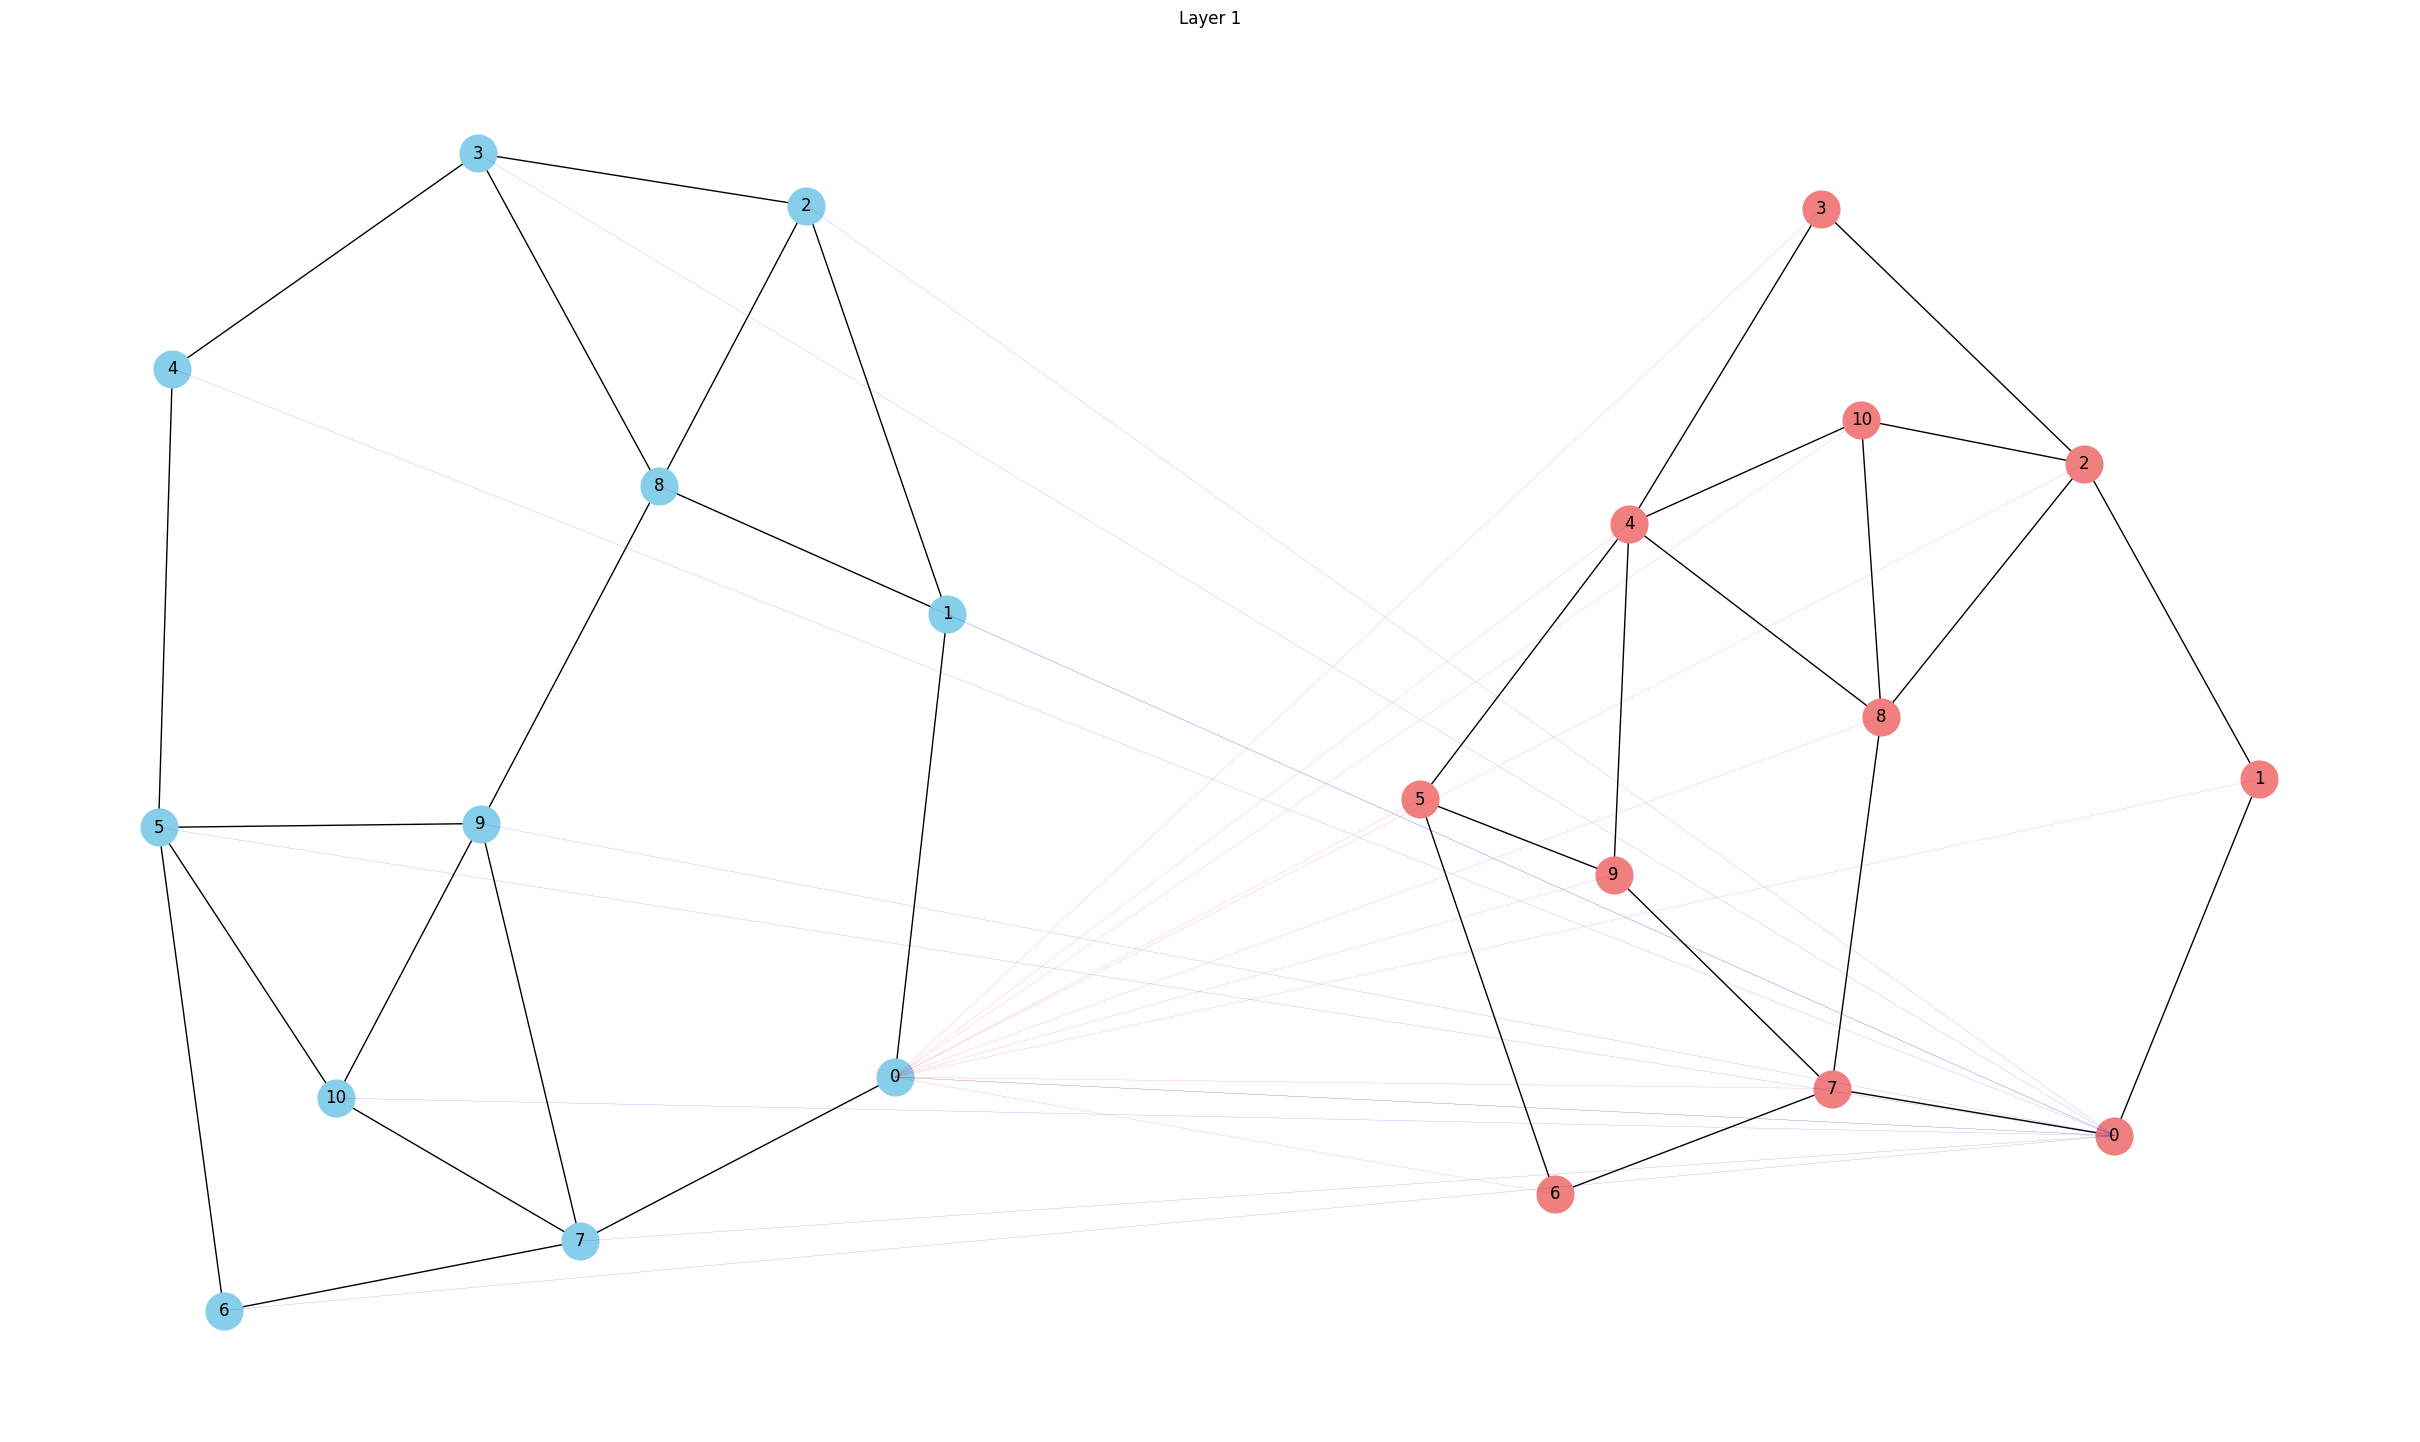

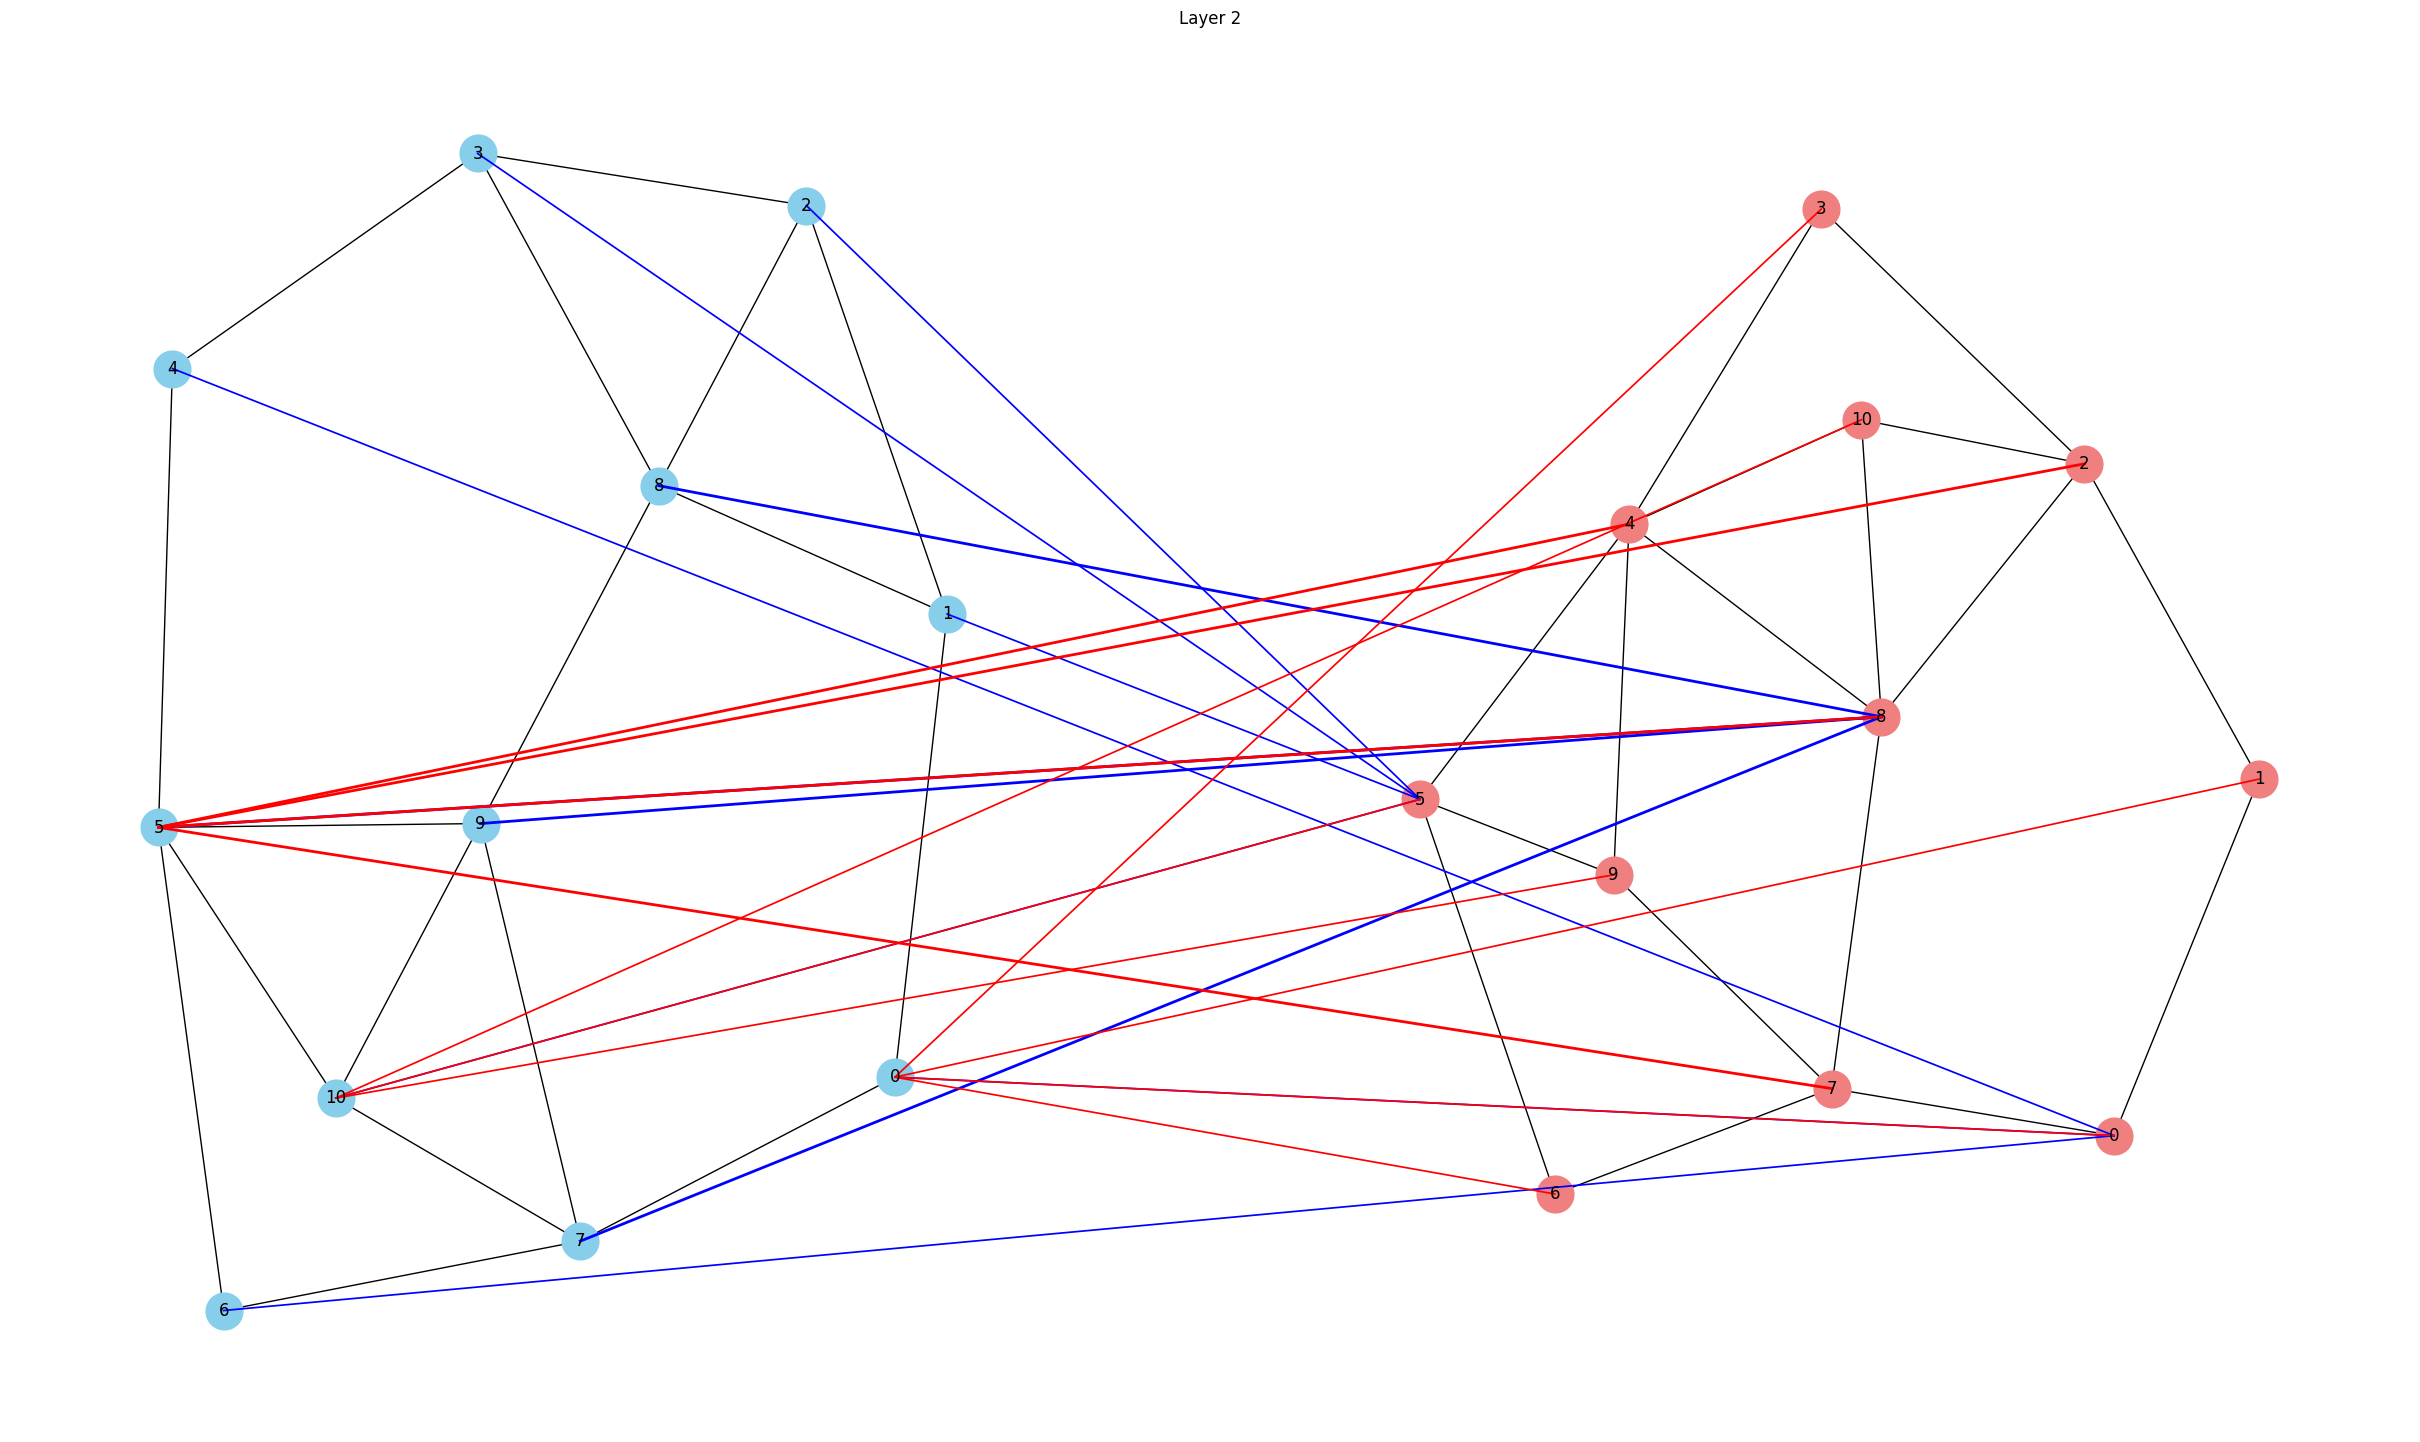

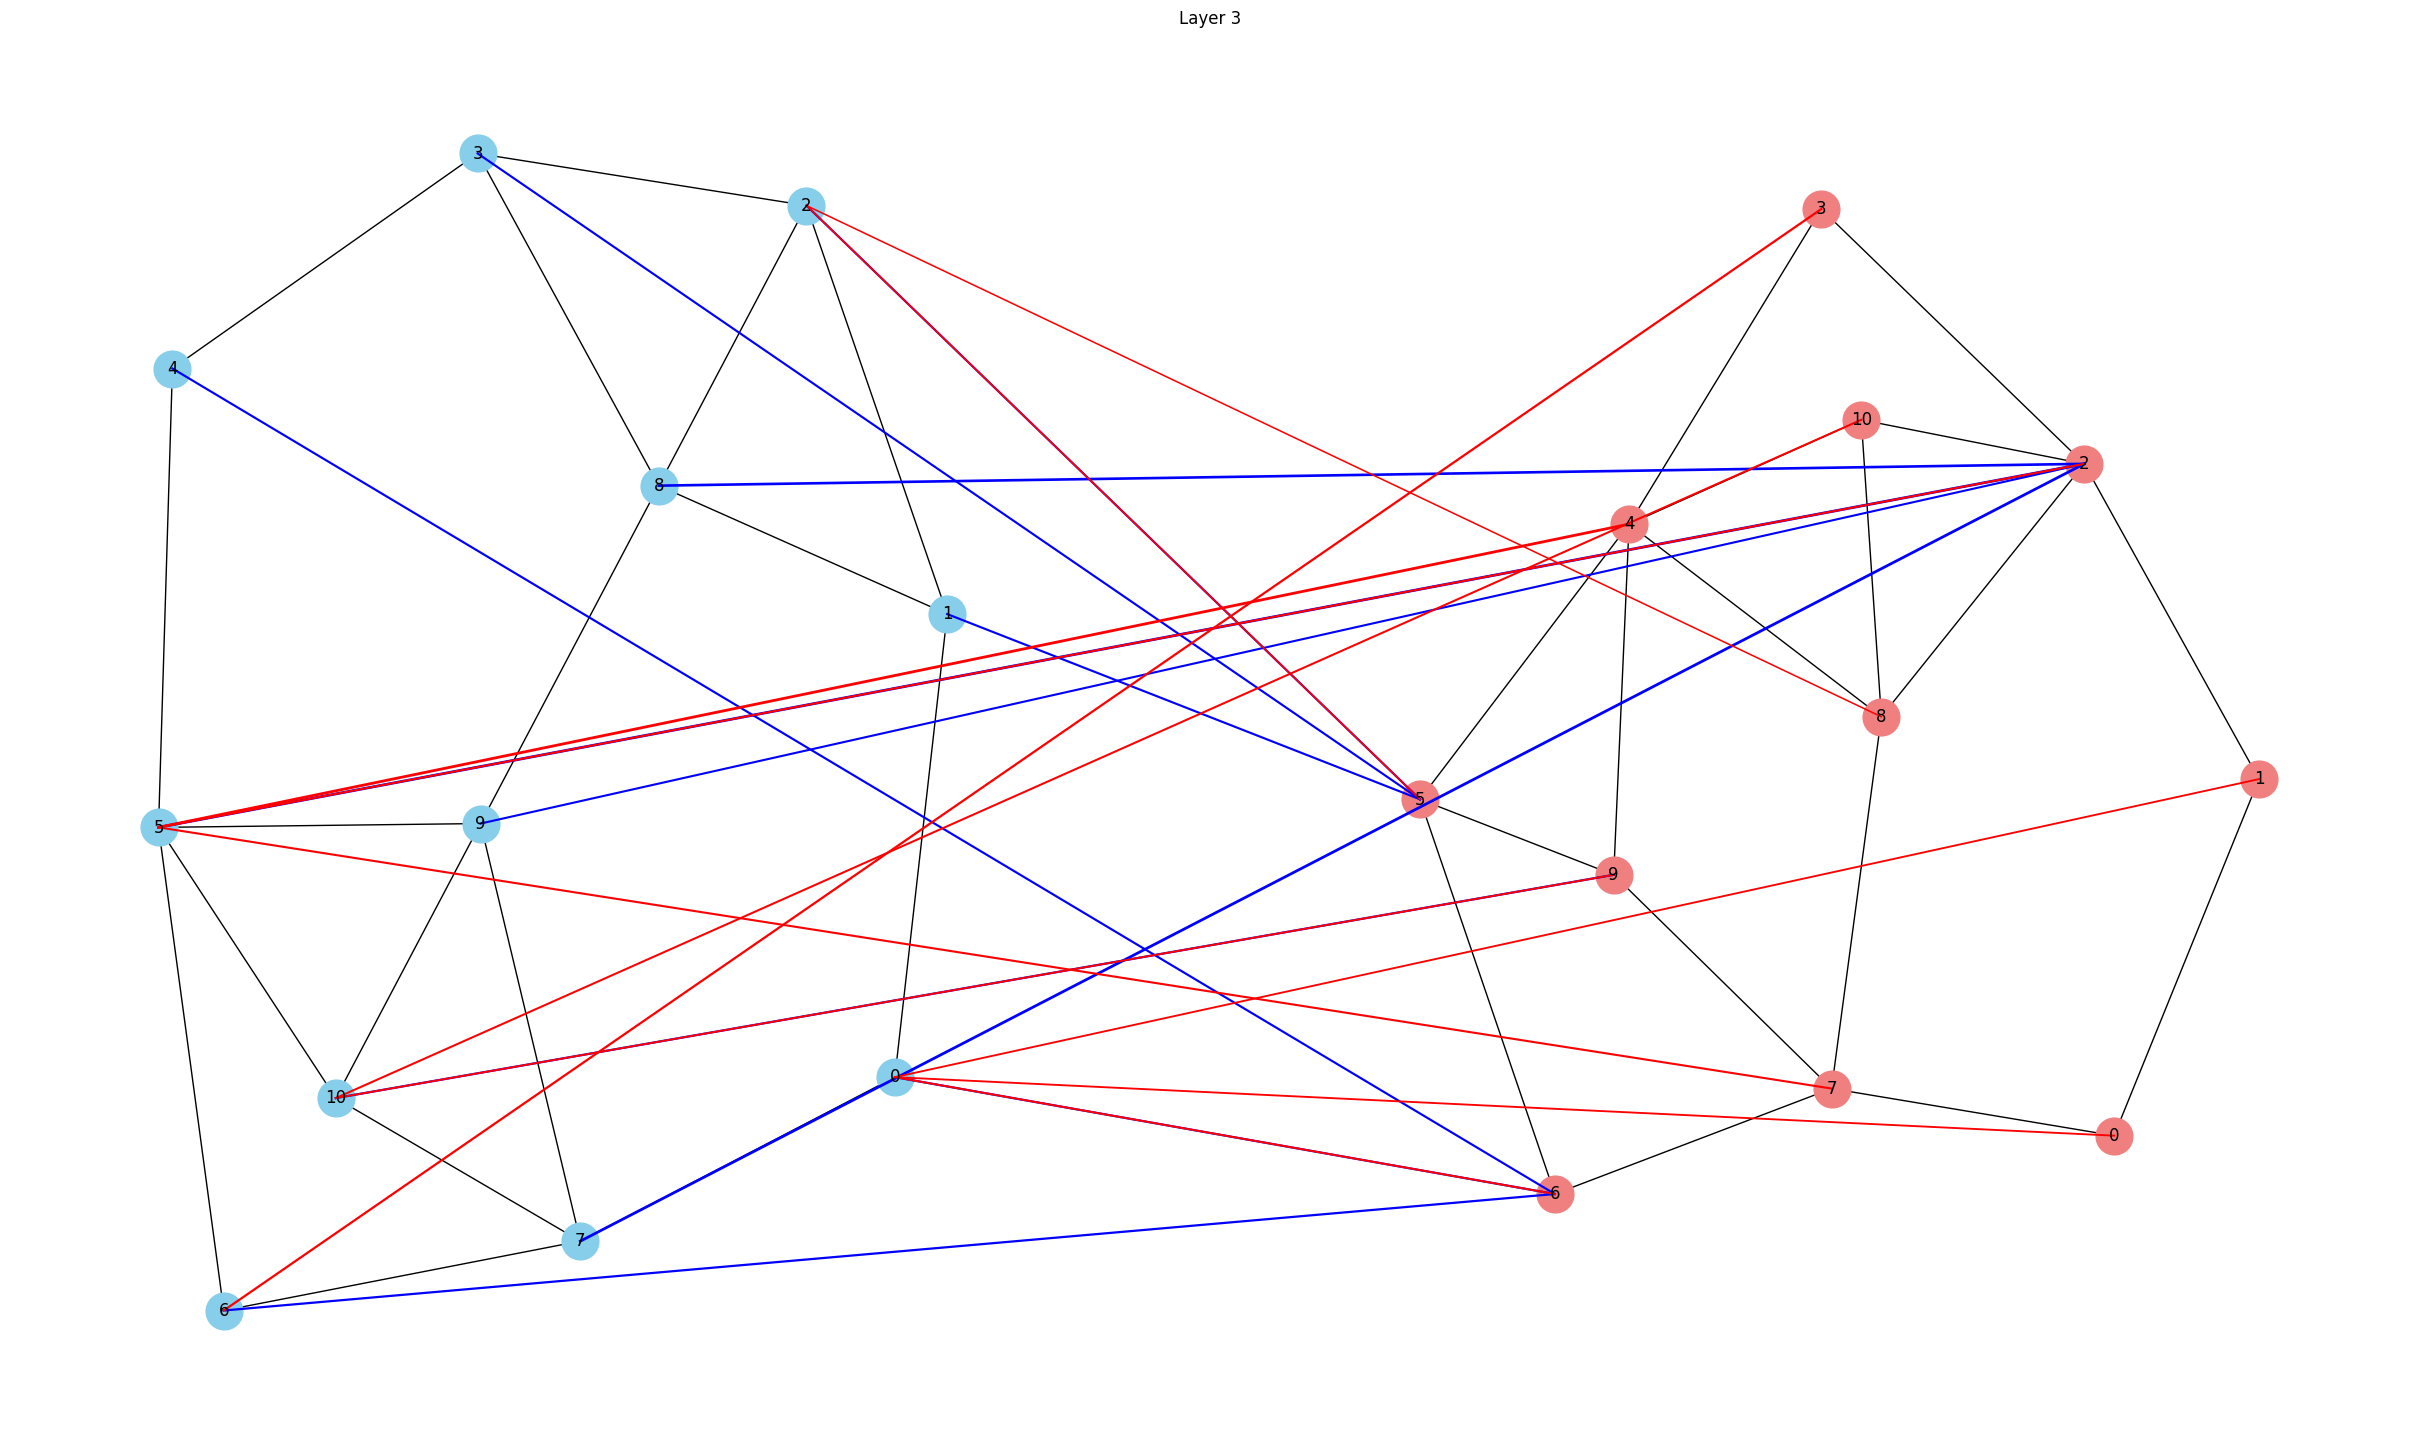

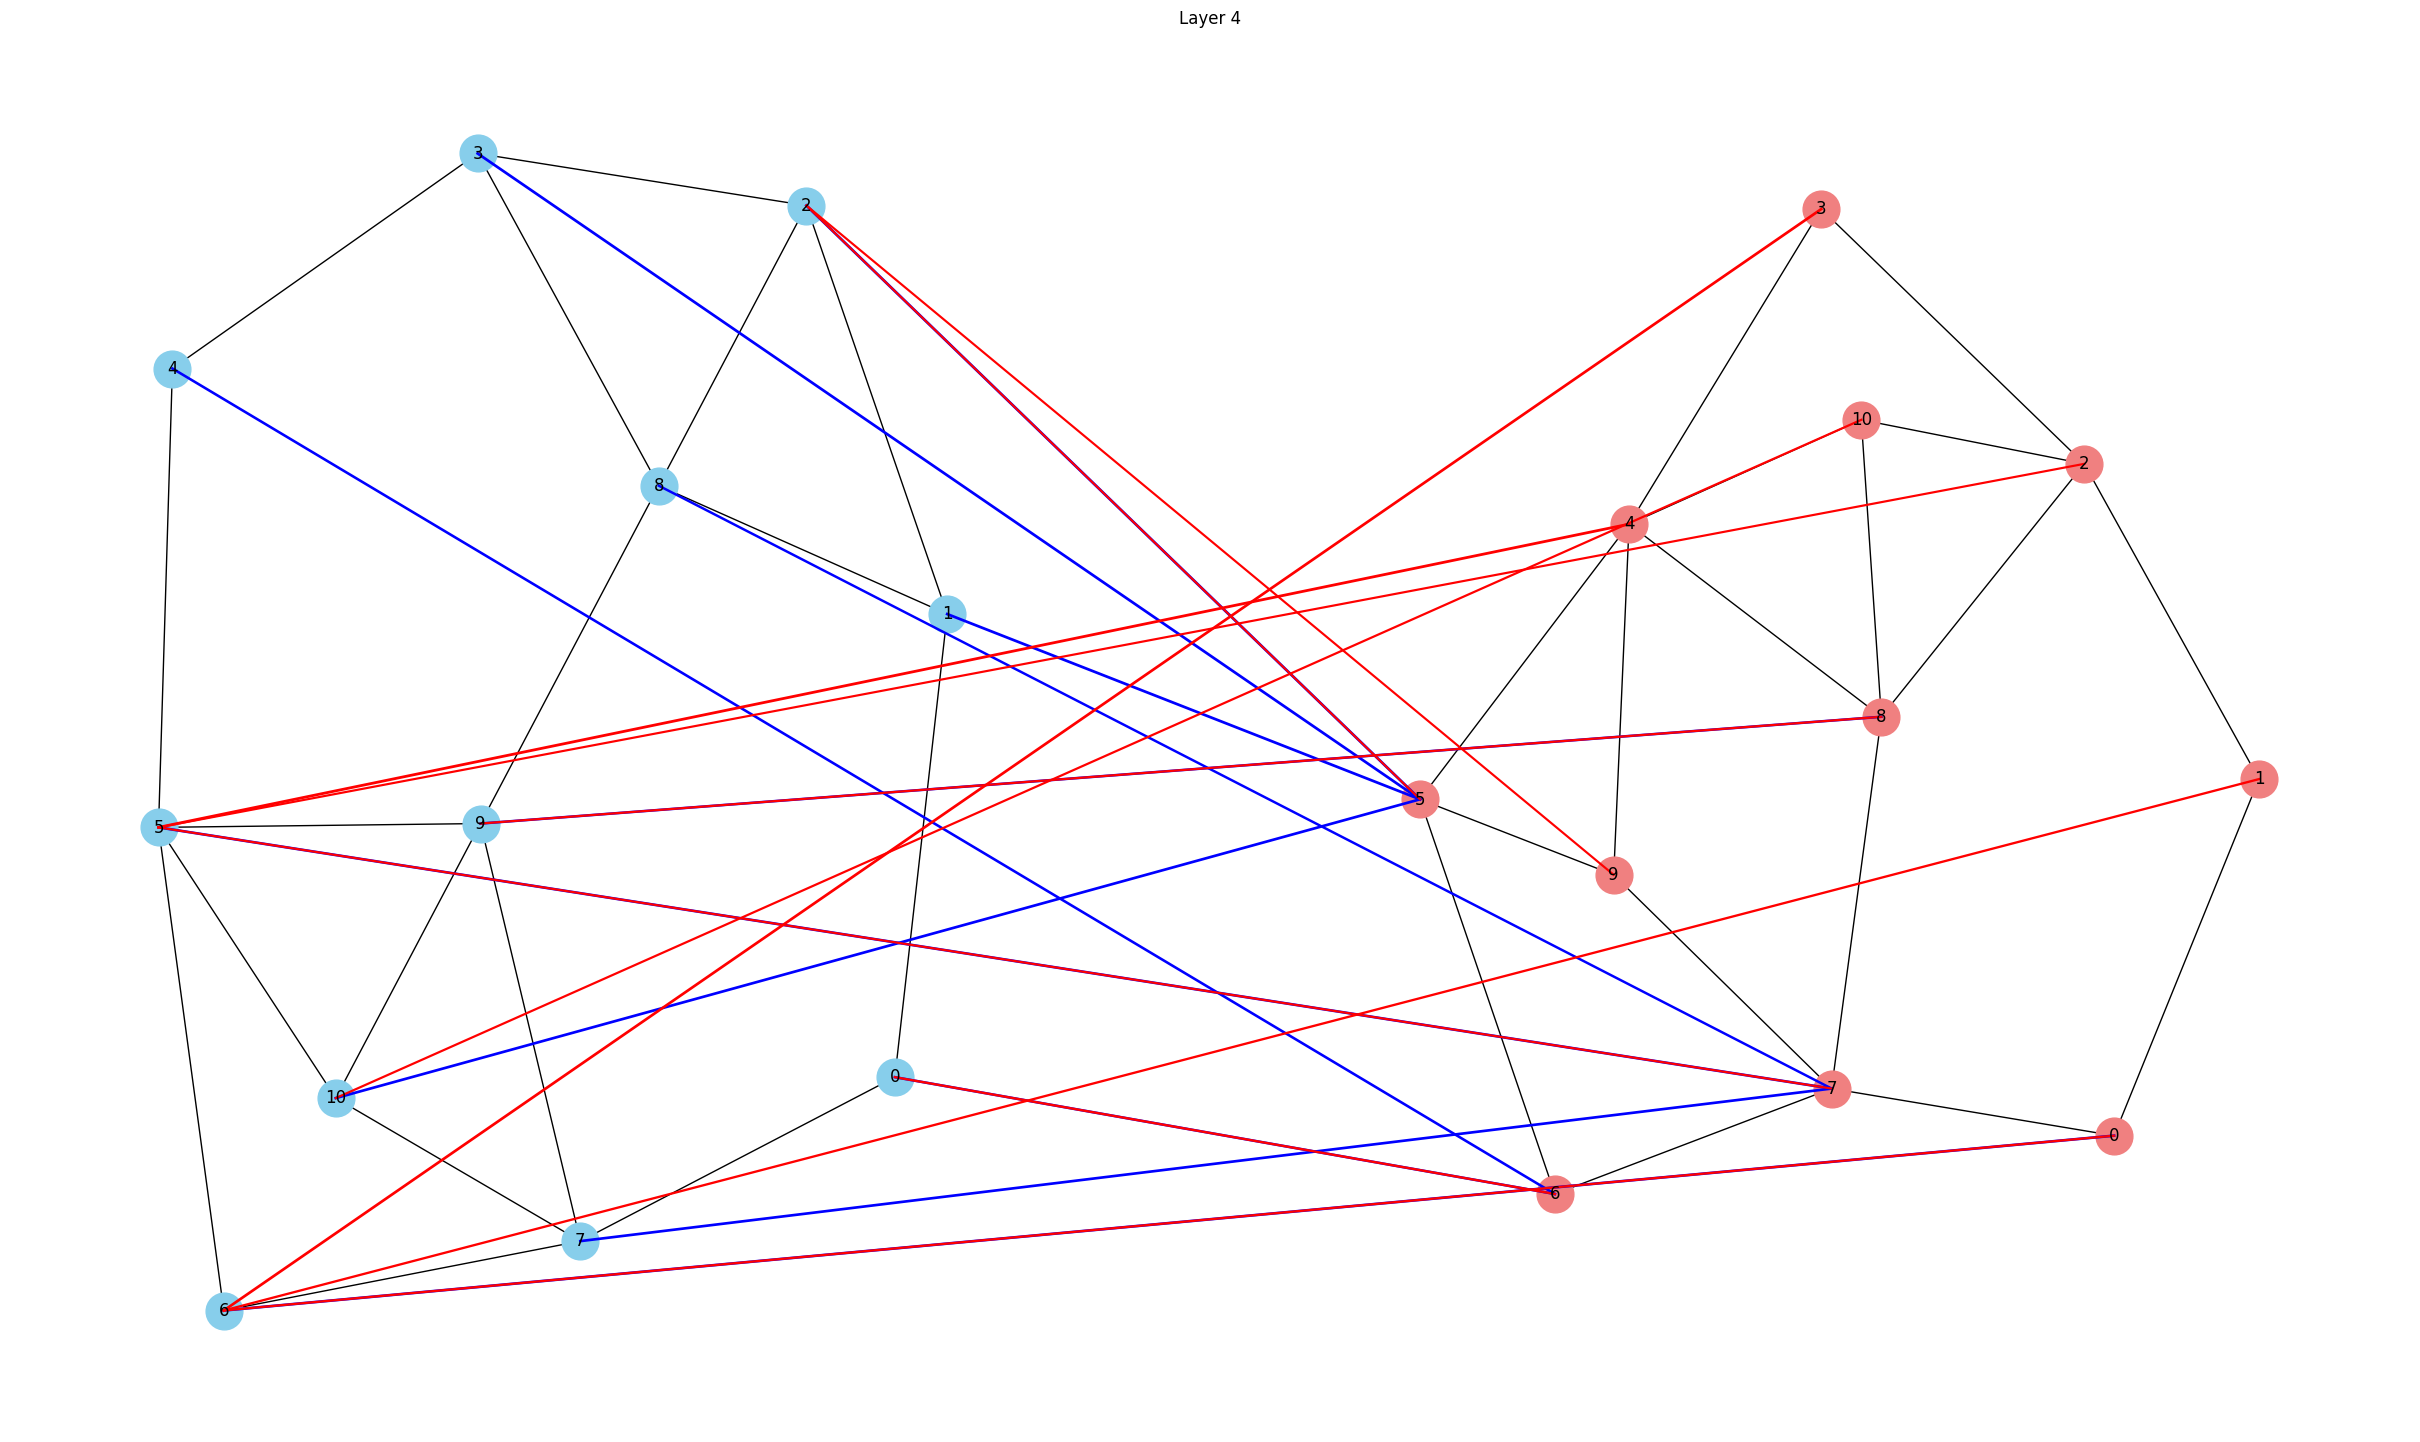

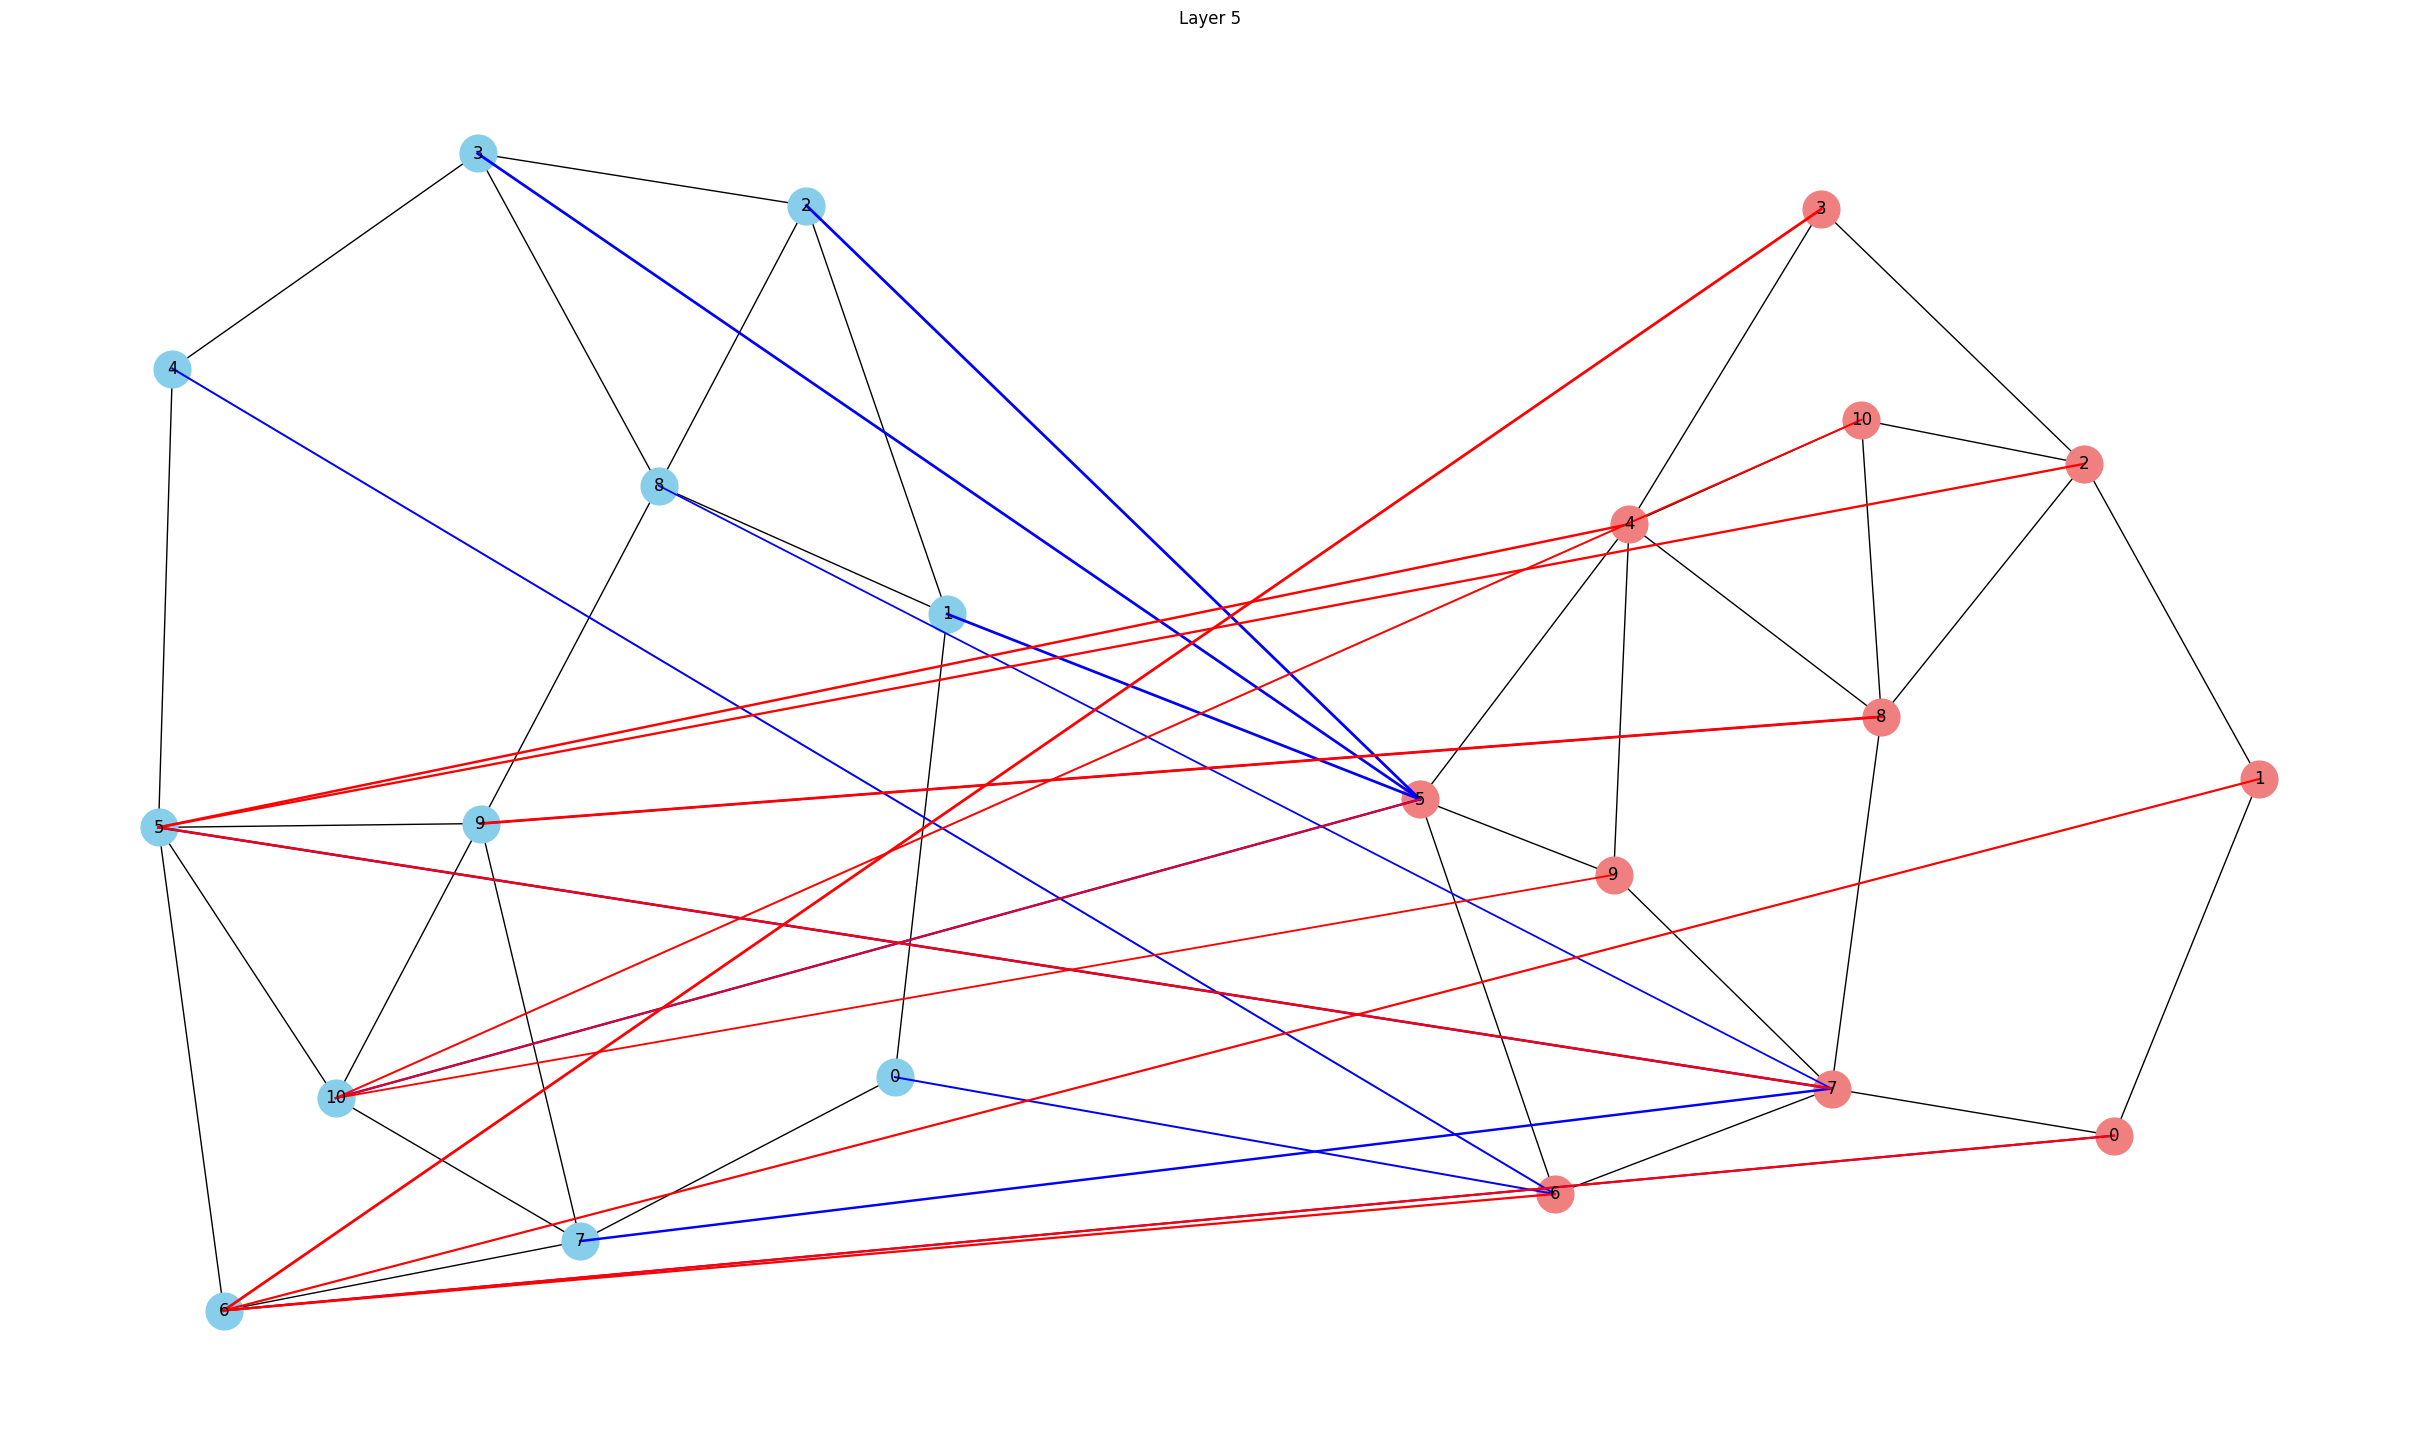

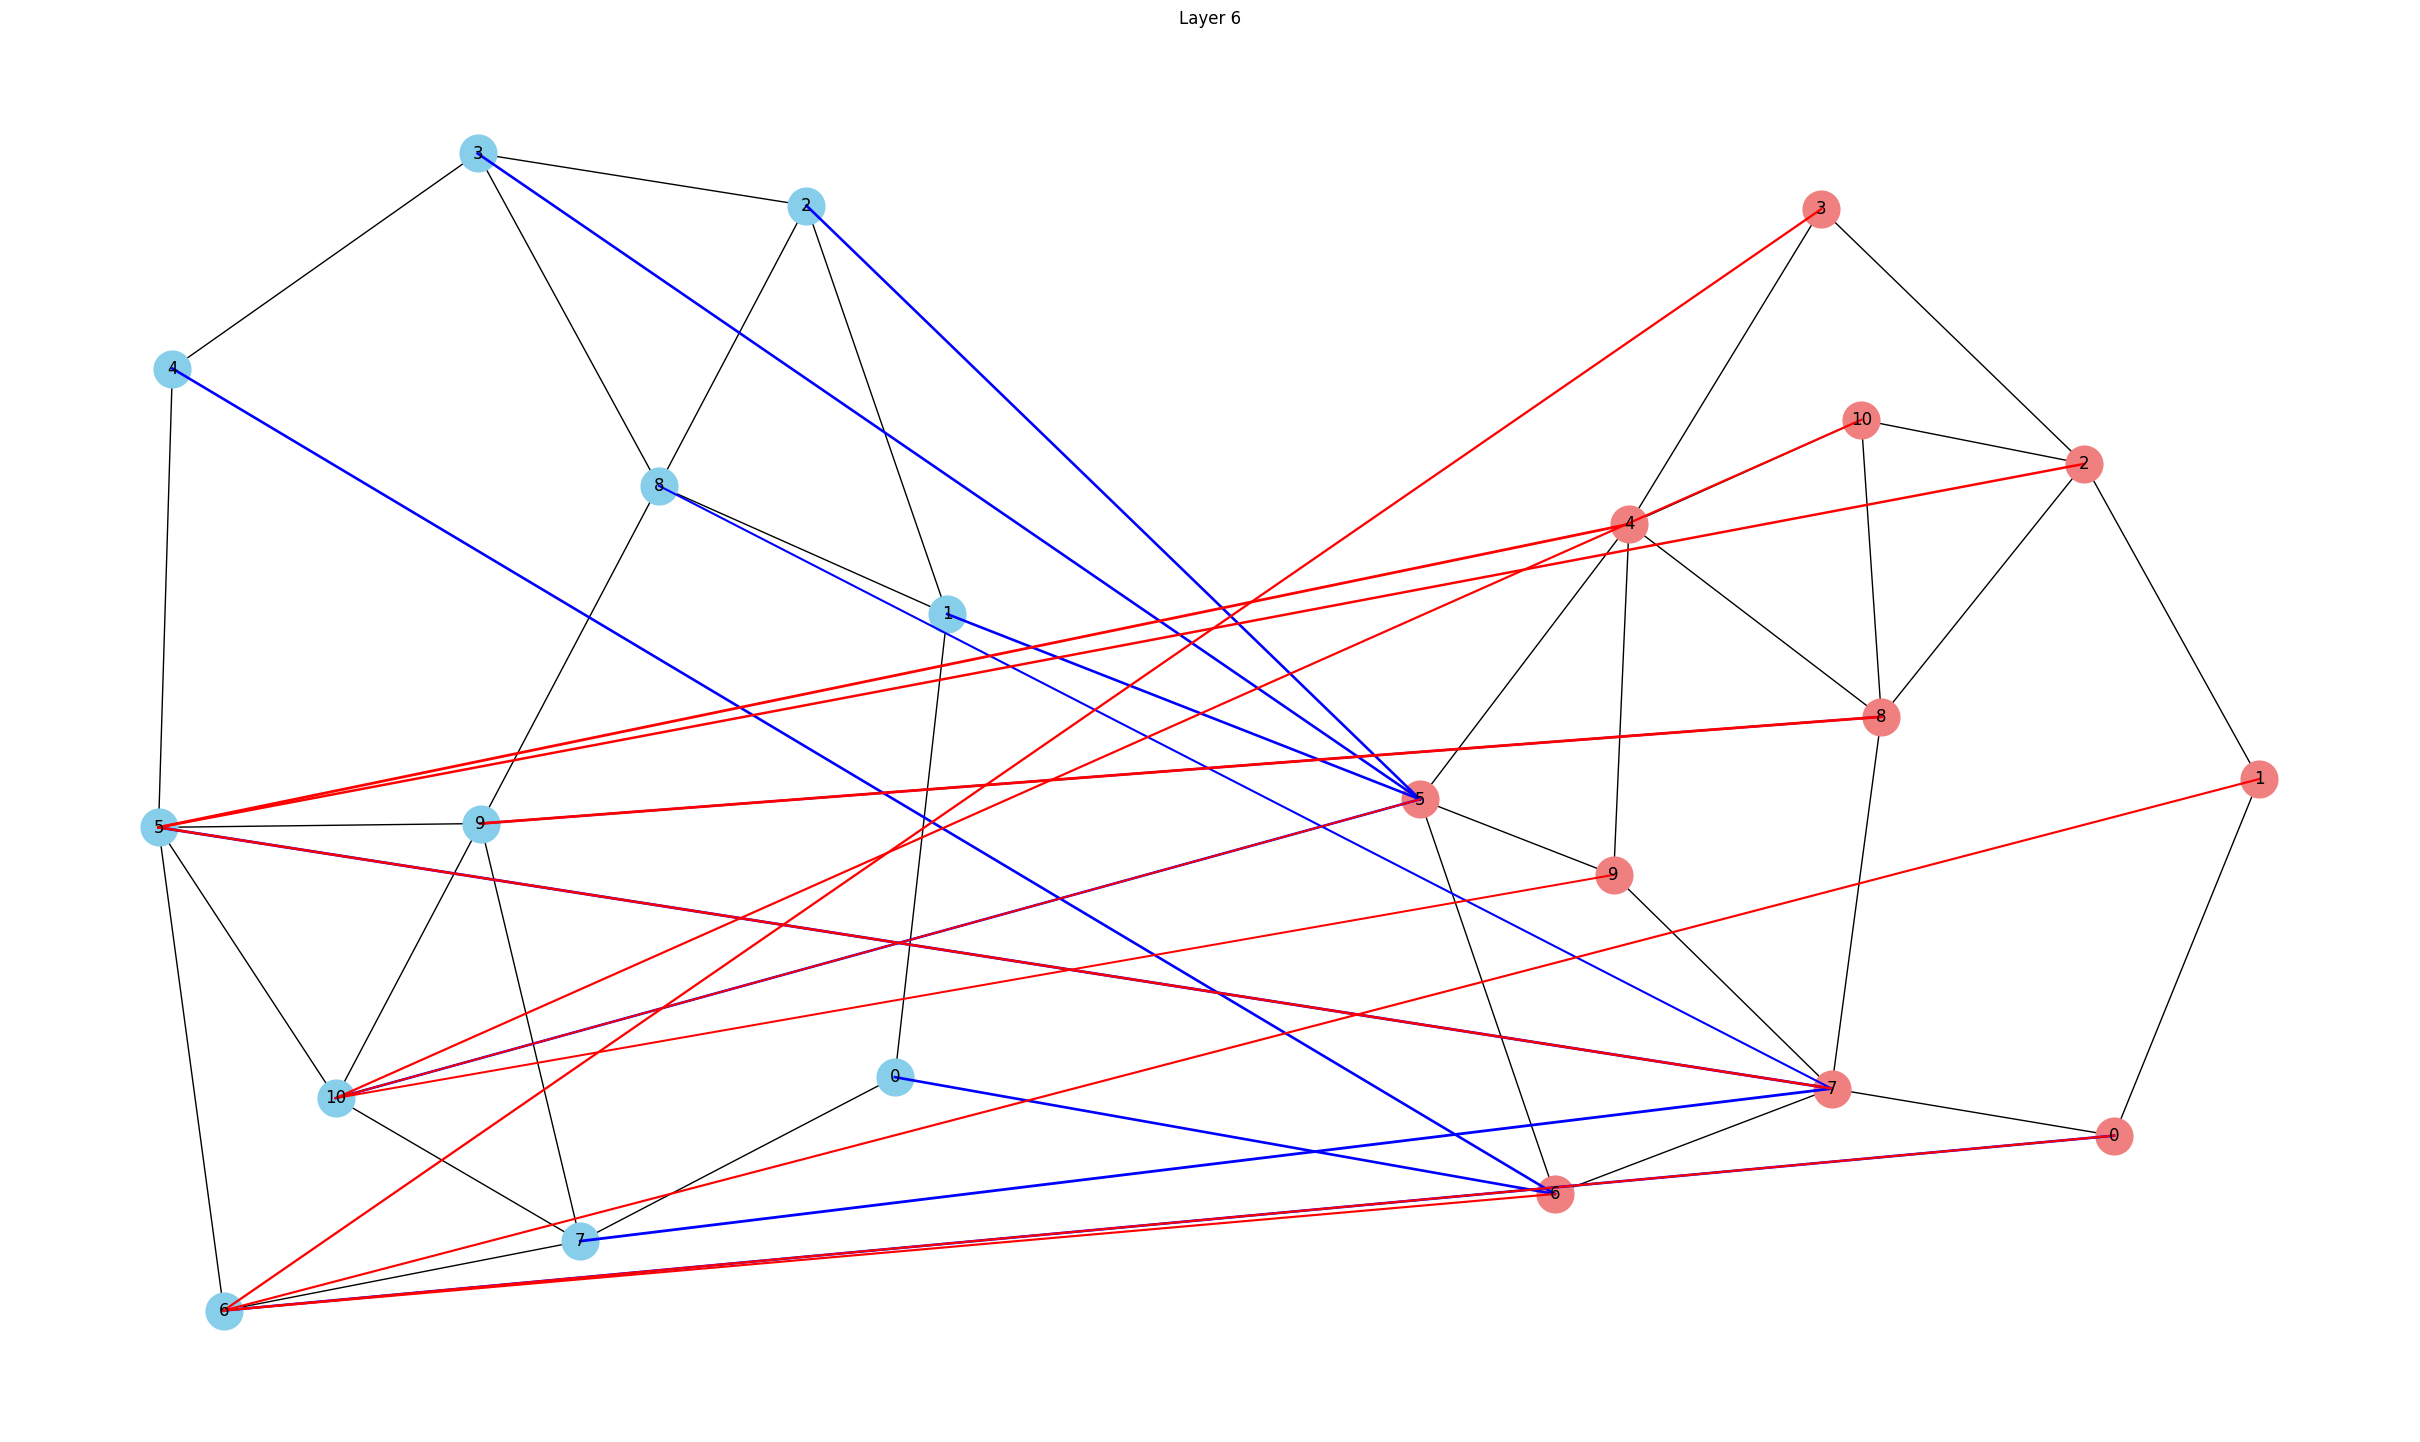

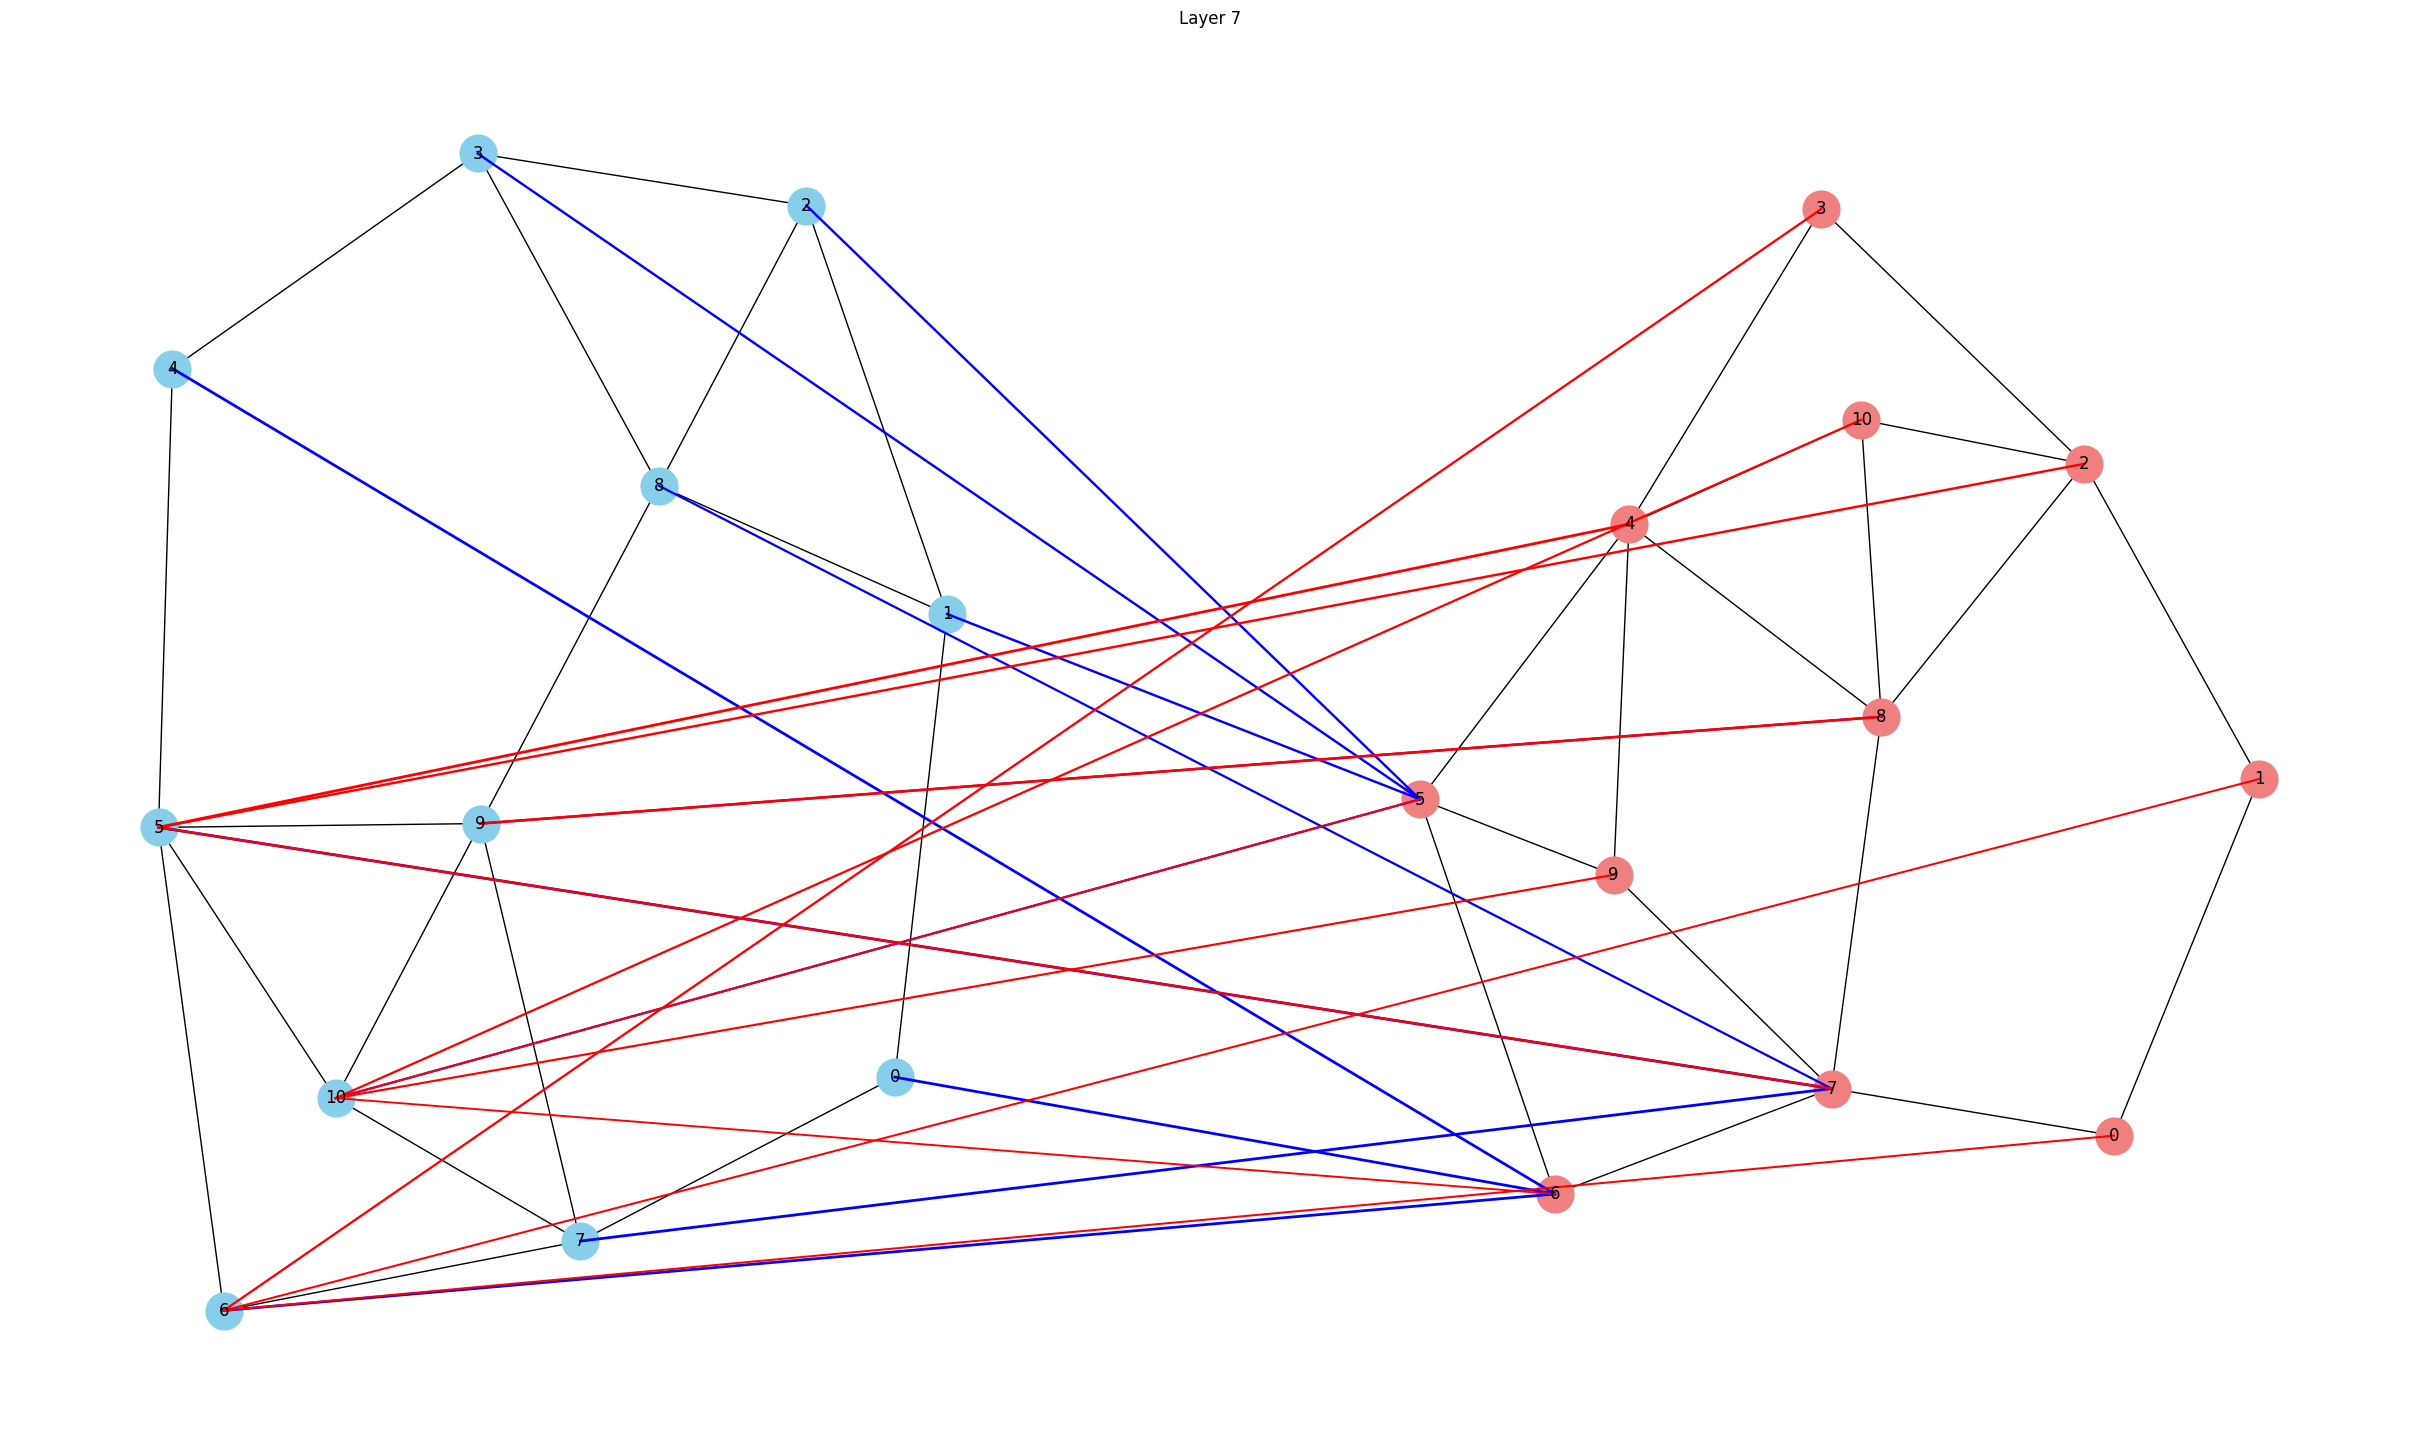

In [16]:
for i in range(len(m.layer_cross_attentions)):
    cross_attentions, a_x_s, a_y_s = m.layer_cross_attentions[i]
    visualize_graphs_with_attention(
        graph1, graph2, a_x_s[0], a_y_s[0], threshold=0.0, topk=1, title=f"Layer {i+1}"
    )

In [ ]:
# class Args:
#     def __init__(self, dim, num_layers, margin, lr, batch_size, num_pairs):
#         self.dim = dim
#         self.feat_dim = dataset.num_features
#         self.num_layers = num_layers
#         self.margin = margin
#         self.lr = lr
#         self.n_classes = dataset.num_classes
#         self.batch_size = batch_size
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.n_clusters = 8
#         self.num_pairs = num_pairs


# dims = [16]
# # num_layers_s = [4, 5, 6, 7, 8]
# num_layers_s = [8]
# margins = [0.1, 0.2, 0.3, 0.4, 0.5]
# lrs = [0.01, 0.001, 0.0001]
# batch_sizes = [16, 32, 64, 128]
# num_pairs_s = [500, 1000, 2000, 3000]


# for hyperparams in itertools.product(
#     dims, num_layers_s, margins, lrs, batch_sizes, num_pairs_s
# ):
#     args = Args(*hyperparams)
#     m = GraphMatchingNetwork(args)
#     o = Adam(m.parameters(), lr=args.lr, weight_decay=1e-5)
#     p, l = create_graph_pairs(dataset, args.num_pairs)
#     train(m, o, p, l, args.batch_size)
#     title = f"Dim:{args.dim},NumLayers:{args.num_layers},Margin:{args.margin},LearningRate:{args.lr},BatchSize:{args.batch_size},NumPairs:{args.num_pairs}"
#     test(m, title, args.num_layers)